In [1]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

from sklearn.datasets import make_classification, make_blobs, make_spd_matrix
from scipy.spatial.distance import pdist, squareform

import sys
sys.path.append('C:\\Users\\Shagesh\\Documents\\Python Scripts\\python_work\\mantis-master')
from mantis import sdp_km_burer_monteiro
from numpy.linalg import eigh

Populating the interactive namespace from numpy and matplotlib


In [8]:
[X, Y] = make_blobs(1500, 10, 3, shuffle = True)

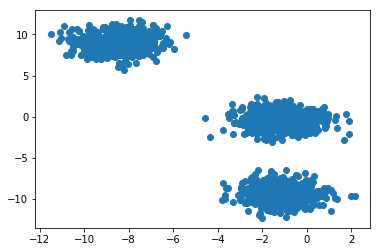

In [9]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [10]:
data = torch.from_numpy(X)

categories = torch.from_numpy(Y)

# Create DataLoader
#dataloader_args = dict(shuffle=True, batch_size=1,num_workers=1, pin_memory=True)
#train_loader = dataloader.DataLoader(train, **dataloader_args)
#test_loader = dataloader.DataLoader(test, **dataloader_args)

In [11]:
Y = sdp_km_burer_monteiro(X, 20, rank=len(X),
                                  tol=1e-6, maxiter=5000, verbose=True)

   0 | Y bounds 0.00000 0.00678 | constraints -16.8959573244 0.0352560565 | E 2.5458639160
   1 | Y bounds 0.00000 0.00678 | constraints -16.8985962749 0.0338208669 | E 0.0004475204
   2 | Y bounds 0.00000 0.00678 | constraints -16.8986146927 0.0338088373 | E 0.0000036844
   3 | Y bounds 0.00000 0.00678 | constraints -16.8985955846 0.0338033210 | E 0.0000053627
   4 | Y bounds 0.00000 0.00678 | constraints -16.8986202519 0.0338000766 | E 0.0000045309
   5 | Y bounds 0.00000 0.00678 | constraints -16.8986048420 0.0338055622 | E 0.0000027999
   6 | Y bounds 0.00000 0.00678 | constraints -16.8986097752 0.0338053642 | E 0.0000008633


In [123]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - Transformed Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

NameError: name 'train' is not defined

## Model

In [21]:
class Model(nn.Module):
    def __init__(self, n_inputs, n_neurons, Wx_in, Wy_in, Y_hat_in, Wx_learning_rate, Wy_learning_rate):
        super(Model, self).__init__()
        
        self.Wx = Wx_in.float() # n_neurons x n_input
        self.Wy = Wy_in.float() # n_neurons X n_neurons
        self.Y_hat = Y_hat_in.float() # n_neurons x 1
        
        self.Y0 = torch.randn(n_neurons, 1).float() # n_neurons x 1
        
        self.eta = 0.1 # learning rate
        self.eta_Wx = Wx_learning_rate
        self.eta_Wy = Wy_learning_rate
        self.ceiling = 100 # maximum activity
        self.input_size = n_inputs
        self.neuron_size = n_neurons
        self.error_Wx = 10**5
        self.error_Wy = 10**5
    
    def forward(self, X1):
#        self.Y0 = torch.ReLU(torch.mm(X0, self.Wx) + self.b) # batch_size X n_neurons
        X1 = X1.float()
        Y_derivative = torch.mm(self.Wx, X1) - torch.mm(self.Wy, self.Y0) # batch_size X n_neurons, highest activity 100
        return Y_derivative
    
    def updateY(self, Y_in):
        Y_in = Y_in.float()
        self.Y0 = self.Y0 + self.eta*(Y_in)
        self.Y0[self.Y0 < 0] = 0
        return self.Y0

    def updateY_hat(self, outputs):
        outputs = outputs.float()
        self.Y_hat += torch.mul(outputs, outputs)
#        self.Y_hat = torch.clamp(self.Y0, -10**10, 10**10)
        self.Y_hat[torch.isnan(self.Y_hat)] = 0
        
    def updateWy(self, outputs):
        outputs = outputs.float()
        D = torch.diag(torch.diag(self.Wy))
#        change_Wy = torch.div(torch.mm(outputs, outputs.T) - torch.mul(self.Wy, torch.mm(torch.mul(outputs, outputs), torch.ones((1, self.neuron_size)))), torch.mm(self.Y_hat, torch.ones((1, self.neuron_size))) + 10**-30)
        change_Wy = torch.mm(outputs, outputs.T) - self.Wy
        mag_change = torch.sqrt(torch.mul(change_Wy, change_Wy).mean())
#        if mag_change < self.error_Wy:
#            self.eta_Wy += 0.001
#            self.error_Wy = mag_change
#        if mag_change > self.error_Wy + 10**-5:
#            self.eta_Wy -= 0.01
#            self.error_Wy = mag_change
#        if self.eta_Wy <= 0:
#            self.eta_Wy = 10**-2
        self.Wy += self.eta_Wy*change_Wy
#        self.Wy += self.eta*torch.mul(torch.mm(outputs.T, outputs) - self.Wy, torch.mm(torch.ones((self.neuron_size, 1)), torch.mul(outputs, outputs)))
        self.Wy = self.Wy - torch.diag(torch.diag(self.Wy)) + D
        self.Wy[torch.isnan(self.Wy)] = 10
#        self.Wy = torch.clamp(self.Wy, -10**10, 10**10)

    def updateWx(self, outputs, inputs):
        inputs = inputs.float()
        outputs = outputs.float()
#        change_Wx = torch.div(torch.mm(outputs, inputs.T) - torch.mul(self.Wx, torch.mm(torch.mul(outputs, outputs), torch.ones((1, self.input_size)))), torch.mm(self.Y_hat, torch.ones((1, self.input_size))) + 10**-30)
        change_Wx = torch.mm(outputs, inputs.T) - self.Wx
        mag_change = torch.sqrt(torch.mul(change_Wx, change_Wx).mean())
#        if mag_change < self.error_Wx:
#            self.eta_Wx += 0.001
#            self.error_Wx = mag_change
#        if mag_change > self.error_Wx + 10**-5:
#            self.eta_Wx -= 0.01
#            self.error_Wx = mag_change
#        if self.eta_Wx <= 0:
#            self.eta_Wx = 10**-2
        self.Wx += self.eta_Wx*change_Wx
#        self.Wx += self.eta*torch.mul(torch.mm(inputs.T, outputs) - self.Wx, torch.mm(torch.ones((self.input_size, 1)), torch.mul(outputs, outputs)))
        self.Wx[torch.isnan(self.Wx)] = 10
#        self.Wx = torch.clamp(self.Wx, -10**10, 10**10)

N_INPUT = 10 # number of features in input
N_NEURONS = 20 # number of units in layer
Wx_learning_rate_1 = 10**-10
Wy_learning_rate_1 = 10**-10

N_INPUT_2 = 20 # number of features in input
N_NEURONS_2 = 3 # number of units in layer
Wx_learning_rate_2 = 10**-10
Wy_learning_rate_2 = 10**-10

#model = Model(N_INPUT, N_NEURONS, torch.randn(N_NEURONS, N_INPUT), torch.from_numpy(make_spd_matrix(N_NEURONS)).float() + 5*torch.diag(torch.ones(N_NEURONS)), torch.randn(N_NEURONS, 1), W_learning_rate_1)
#model_2 = Model(N_INPUT_2, N_NEURONS_2, torch.randn(N_NEURONS_2, N_INPUT_2), torch.from_numpy(make_spd_matrix(N_NEURONS_2)).float() + 5*torch.diag(torch.ones(N_NEURONS_2)), torch.randn(N_NEURONS_2, 1), W_learning_rate_2)
model = Model(N_INPUT, N_NEURONS, torch.randn(N_NEURONS, N_INPUT), 1*torch.ones(N_NEURONS, N_NEURONS) - 1*torch.diag(torch.ones(N_NEURONS)), torch.randn(N_NEURONS, 1), Wx_learning_rate_1, Wy_learning_rate_1)
model_2 = Model(N_INPUT_2, N_NEURONS_2, torch.randn(N_NEURONS_2, N_INPUT_2), 1*torch.ones(N_NEURONS_2, N_NEURONS_2) - 1*torch.diag(torch.ones(N_NEURONS_2)), torch.randn(N_NEURONS_2, 1), Wx_learning_rate_2, Wy_learning_rate_2)
criterion = torch.nn.MSELoss()
criterion_check = torch.nn.MSELoss()
model.cuda() # CUDA!
model_2.cuda() # CUDA!
#optimizer = optim.Adam(model.parameters(), lr=0.001)

Model()

In [111]:
i = 0

tensor(0.)


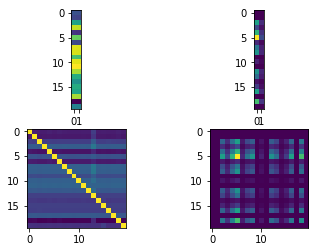

tensor(0.)


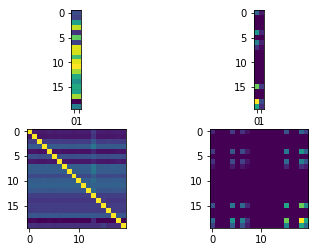

tensor(0.)


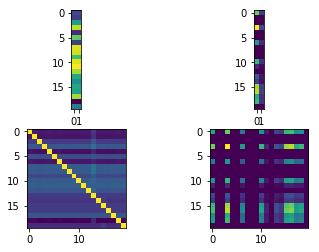

tensor(0.)


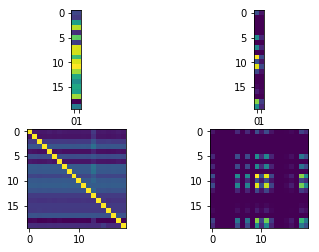

tensor(0.)


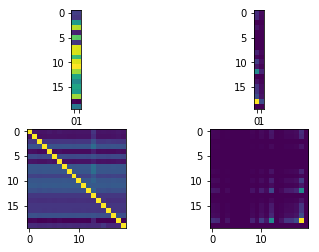

tensor(0.)


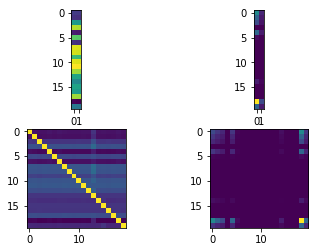

tensor(0.)


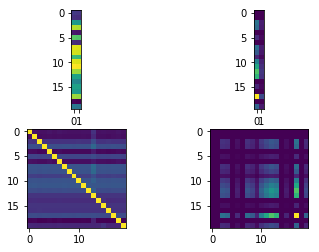

tensor(0.)


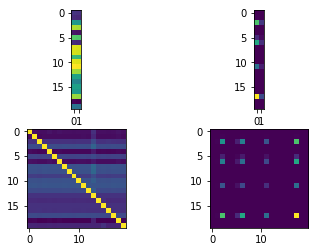

tensor(0.)


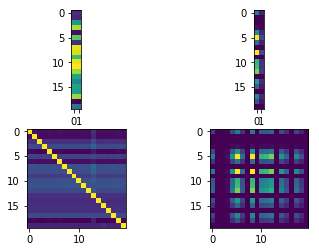

tensor(0.)


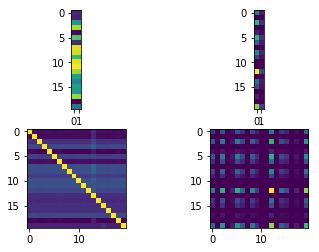

In [114]:
for k in range(100):
    inputs = data[i]
    labels = categories[i]
        # get the inputs; data is a list of [inputs, labels]
    model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, W_learning_rate_1)
    model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, W_learning_rate_2)

    # forward + backward + optimize
    outputs = model.forward(inputs.flatten().view(-1, 2).T)
    loss = criterion(outputs, model.Y0)
    model.updateY(outputs)
        
    j = 0
    while(loss > 10**-5 and j < 10**5):
        outputs = model.forward(inputs.flatten().view(-1, 2).T)
        loss = criterion(outputs, model.Y0)
        model.updateY(outputs)
        j += 1
#        print(i, "loss:", loss)
        
    model.updateY_hat(outputs)
    model.updateWx(outputs, inputs.view(-1, 2).T)
    model.updateWy(outputs)       
    if k % 10 == 9:
        print(criterion(outputs, model.Y0))
        f, axarr = plt.subplots(2,2)
        axarr[0, 0].imshow(model.Wx)
        axarr[0, 1].imshow(torch.mm(outputs, inputs.float().view(2, 1).T))
        axarr[1, 0].imshow(model.Wy)
        axarr[1, 1].imshow(torch.mm(outputs, outputs.T))
        plt.show()

tensor(0.)


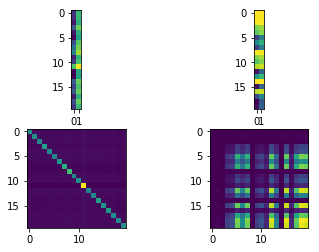

In [52]:
print(criterion(outputs, model.Y0))
f, axarr = plt.subplots(2,2)
axarr[0, 0].imshow(model.Wx)
axarr[0, 1].imshow(torch.mm(outputs, inputs.float().view(2, 1).T))
axarr[1, 0].imshow(model.Wy)
axarr[1, 1].imshow(torch.mm(outputs, outputs.T))

In [18]:
Y_arranged = Y[np.argsort(categories)]

In [19]:
Q = np.dot(Y_arranged, Y_arranged.T)

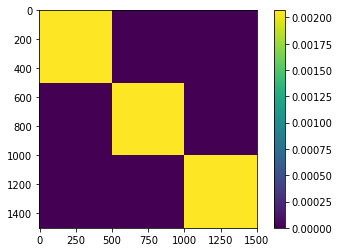

In [20]:
imshow(Q)
colorbar()

In [106]:
Wx_learning_rate_1 = 10**-8
Wy_learning_rate_1 = 10**-8

Wx_learning_rate_2 = 10**-4
Wy_learning_rate_2 = 10**-4

In [22]:
model.train()
output_compare = torch.ones(3, 3)

losses = []
for epoch in range(5):
    for i in range(1500):
        inputs = data[i]
        labels = categories[i]
        # get the inputs; data is a list of [inputs, labels]
        model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, model.eta_Wx, model.eta_Wy)
        model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, model_2.eta_Wx, model_2.eta_Wy)

        # forward + backward + optimize
        old_output = model.Y0
        derivative = model.forward(inputs.flatten().view(-1, 10).T)
        outputs = model.updateY(derivative)
        loss = criterion(outputs, old_output)
        
        j = 0
        while(loss > 10**-5 and j < 10**3):
            old_output = model.Y0
            derivative = model.forward(inputs.flatten().view(-1, 10).T)
            outputs = model.updateY(derivative)
            loss = criterion(outputs, model.Y0)
            j += 1
#            if j % 1000 == 999:
#                print(j, "loss:", loss)
        
        model.updateY_hat(outputs)
        model.updateWx(outputs, inputs.view(-1, 10).T)
        model.updateWy(outputs)        

        # forward + backward + optimize
        old_output_2 = model_2.Y0
        derivative_2 = model_2.forward(outputs)
        outputs_2 = model_2.updateY(derivative_2)
        loss_2 = criterion(outputs_2, old_output_2)
        
        j = 0
        while(loss_2 > 10**-5 and j < 10**3):
            old_output_2 = model_2.Y0
            derivative_2 = model_2.forward(outputs)
            outputs_2 = model_2.updateY(derivative_2)
            loss_2 = criterion(outputs_2, old_output_2)
            j += 1
#            if j % 1000 == 999:
#                print(j, "loss:", loss)
        
        model_2.updateY_hat(outputs_2)
        model_2.updateWx(outputs_2, outputs)
        model_2.updateWy(outputs_2)        
        
        loss_check = criterion_check(outputs_2.T[0], output_compare[labels])
        losses.append(loss_check)
        output_compare[labels] = outputs_2.T
                
        # Display
        if i % 10 == 9:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                i , 
                1500,
                100. * i / 1500, 
                loss_check), 
                end='')
            
    print()

 Train Epoch: 0 [1499/1500 (100%)]	Loss: 12426.607422
 Train Epoch: 1 [1499/1500 (100%)]	Loss: 1190187.625000
 Train Epoch: 2 [1499/1500 (100%)]	Loss: 74181.765625
 Train Epoch: 3 [1499/1500 (100%)]	Loss: 49875.519531
 Train Epoch: 4 [1499/1500 (100%)]	Loss: 124621.390625


In [23]:
#output_compare
distance = torch.zeros((1500, 20))
distance_2 = torch.zeros((1500, 3))
for i in range(1500):
    inputs = data[i]
    labels = categories[i]
    model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, Wx_learning_rate_1, Wy_learning_rate_1)
    model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, Wx_learning_rate_2, Wy_learning_rate_2)
    old_output = model.Y0
    derivative = model.forward(inputs.flatten().view(-1, 10).T)
    outputs = model.updateY(derivative)
    loss = criterion(outputs, old_output)
    j = 0
    while(loss > 10**-5 and j < 10**3):
        old_output = model.Y0
        derivative = model.forward(inputs.flatten().view(-1, 10).T)
        outputs = model.updateY(derivative)
        loss = criterion(outputs, old_output)
        j += 1
    old_output_2 = model_2.Y0
    derivative_2 = model_2.forward(outputs)
    outputs_2 = model_2.updateY(derivative_2)
    loss_2 = criterion(outputs_2, old_output_2)
    j = 0
    while(loss_2 > 10**-5 and j < 10**3):
        old_output_2 = model_2.Y0
        derivative_2 = model_2.forward(outputs)
        outputs_2 = model_2.updateY(derivative_2)
        loss_2 = criterion(outputs_2, old_output_2)
        j += 1
    distance[i] = outputs.T
    distance_2[i] = outputs_2.T
            # Display
    if i % 10 == 9:
        print('\r Compute output [{}/{} ({:.0f}%)]\t'.format(
            i , 
            1500,
            100. * i / 1500), 
            end='')
            
print()
#    for j in range(2):
#        distance[j] = torch.nn.functional.mse_loss(outputs[0], output_compare[j])
#    print(outputs_2)
#    print(np.argmin(distance.data.numpy()), '   ', labels)

 Compute output [1499/1500 (100%)]	


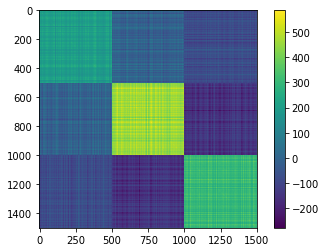

In [25]:
imshow(torch.mm(data[np.argsort(categories)], data[np.argsort(categories)].T))
colorbar()

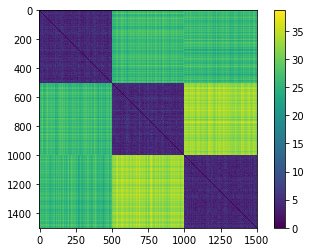

In [26]:
imshow(squareform(pdist(data[np.argsort(categories)])))
colorbar()

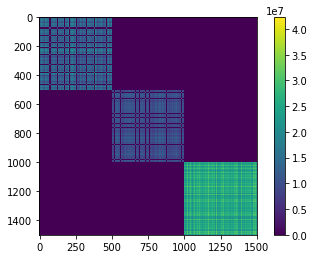

In [29]:
imshow(torch.mm(distance[np.argsort(categories)], distance[np.argsort(categories)].T))
colorbar()

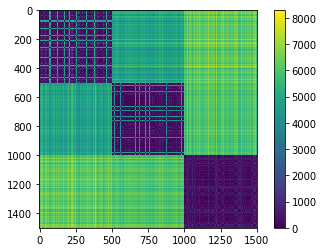

In [27]:
imshow(squareform(pdist(distance[np.argsort(categories)])))
colorbar()

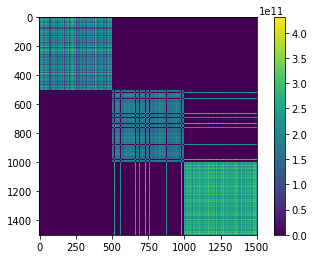

In [30]:
imshow(torch.mm(distance_2[np.argsort(categories)], distance_2[np.argsort(categories)].T))
colorbar()

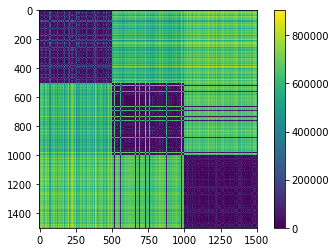

In [28]:
imshow(squareform(pdist(distance_2[np.argsort(categories)])))
colorbar()

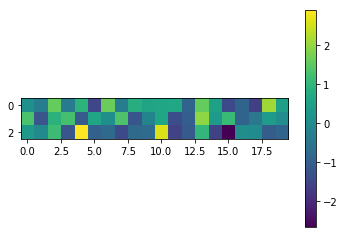

In [105]:
imshow(model_2.Wx)
colorbar()

In [80]:
for i in range(20):
    plt.scatter(X[:,0], X[:,1], c=distance[:, i], cmap='Greys', alpha=0.1)
    colorbar()
    plt.show()

IndexError: too many indices for tensor of dimension 1

In [21]:
distance

tensor([106.7697,   4.1368,   0.0000])

## Evaluate

In [26]:
evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor())).cuda()
evaluate_y = Variable(test_loader.dataset.test_labels).cuda()


output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu().float()
accuracy = d.sum()/d.size()[0]

print('Accuracy:', accuracy)

RuntimeError: matrices expected, got 3D, 2D tensors at C:\w\1\s\tmp_conda_3.7_055457\conda\conda-bld\pytorch_1565416617654\work\aten\src\TH/generic/THTensorMath.cpp:747

In [110]:
#output_compare
distance = torch.zeros(3)
correct_count = 0
for k in range(100):
    i = k*15
    inputs = data[i]
    labels = categories[i]
    model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, Wx_learning_rate_1, Wy_learning_rate_1)
    model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, Wx_learning_rate_2, Wy_learning_rate_2)
    outputs = model.forward(inputs.flatten().view(-1, 10).T)
    j = 0
    old_output = model.Y0
    derivative = model.forward(inputs.flatten().view(-1, 10).T)
    outputs = model.updateY(derivative)
    loss = criterion(outputs, old_output)
    j = 0
    while(loss > 10**-5 and j < 10**3):
        old_output = model.Y0
        derivative = model.forward(inputs.flatten().view(-1, 10).T)
        outputs = model.updateY(derivative)
        loss = criterion(outputs, old_output)
        j += 1
    old_output_2 = model_2.Y0
    derivative_2 = model_2.forward(outputs)
    outputs_2 = model_2.updateY(derivative_2)
    loss_2 = criterion(outputs_2, old_output_2)
    j = 0
    while(loss_2 > 10**-5 and j < 10**3):
        old_output_2 = model_2.Y0
        derivative_2 = model_2.forward(outputs)
        outputs_2 = model_2.updateY(derivative_2)
        loss_2 = criterion(outputs_2, old_output_2)
        j += 1
#    distance[i] = outputs.T
    for j in range(2):
        distance[j] = torch.nn.functional.mse_loss(outputs_2.T[0], output_compare[j])
#    print(outputs_2.T)
    print(np.argmin(distance.data.numpy()), '   ', labels)
    if np.argmin(distance.data.numpy()) == labels:
        correct_count += 1
print(float(correct_count)/100)

2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtyp